In [1]:
import re
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import src.helpers as hlp
from nltk.tokenize import TweetTokenizer
tweet_tokenizer = TweetTokenizer()
from gensim.models import word2vec
from gensim.models import fasttext
import sklearn.decomposition as sk
from sklearn.model_selection import train_test_split
from sklearn import svm
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import torch
import torch.nn as nn
import gensim.downloader as api

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\danie\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\danie\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\danie\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
c:\Users\danie\anaconda3\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [2]:
t_pos = pd.read_table("data/train_pos.txt", header=None, names=['tweet'], dtype=str,on_bad_lines='skip')
t_pos['label'] = 1
t_neg = pd.read_table("data/train_neg.txt", header=None, names=['tweet'], dtype=str,on_bad_lines='skip')
t_neg['label'] = 0
df = pd.concat((t_pos,t_neg))

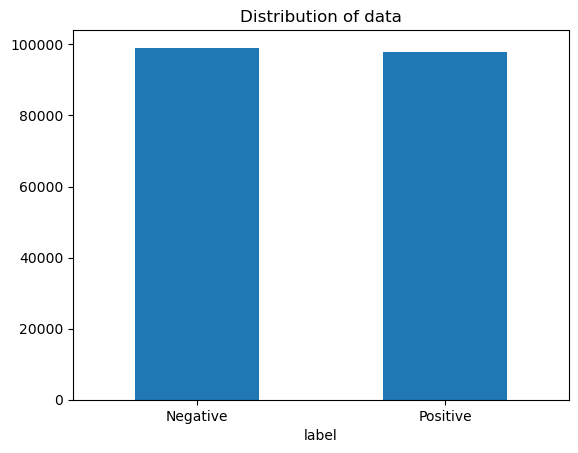

In [3]:
ax = df.groupby('label').count().plot(kind='bar', title='Distribution of data',
                                               legend=False)
ax = ax.set_xticklabels(['Negative','Positive'], rotation=0)

In [4]:
df['tweet'] = df['tweet'].apply(lambda x: hlp.remove_stopwords(x))
df['tweet'] = df['tweet'].apply(lambda x: hlp.remove_punct(x))
df['tweet'] = df['tweet'].apply(lambda x: hlp.add_space(x))
df['tweet'] = df['tweet'].apply(lambda x: hlp.remove_white_space(x))
df['tweet'] = df['tweet'].apply(lambda x: hlp.remove_words_digits(x))
df['tweet'] = df['tweet'].apply(lambda x: hlp.to_lower(x))
df['tweet'] = df['tweet'].apply(lambda x: hlp.remove_specific_words(x))
df['tweet'] = df['tweet'].apply(lambda x: hlp.remove_repeating_char(x))
df['tweet'] = df['tweet'].apply(lambda x: hlp.remove_single_char(x))
df['tweet'] = df['tweet'].apply(lambda x: hlp.lemmatize(x))


In [5]:
df['tweet'] = df['tweet'].apply(lambda s: tweet_tokenizer.tokenize(s))

In [6]:
X_train, X_test, y_train, y_test = train_test_split (df['tweet'], df['label'] , test_size=0.2)

In [7]:
w2c_model = word2vec.Word2Vec(sentences=X_train, vector_size=200, window=5, min_count=1, workers=4)

In [8]:
def vectorize(model_train, dataset):
    words = set(model_train.wv.index_to_key)
    X_train_vect = np.array([np.array([model_train.wv[i] for i in ls if i in words])for ls in dataset])
    X_train_vect_avg = []
    for v in X_train_vect:
        if v.size:
            X_train_vect_avg.append(v.mean(axis=0))
        else:
            X_train_vect_avg.append(np.zeros(200, dtype=float))
    return X_train_vect_avg


In [9]:
w2c_X_train_vect = vectorize(w2c_model, X_train)
w2c_X_test_vect = vectorize(w2c_model, X_test)

C:\Users\danie\AppData\Local\Temp\ipykernel_31832\881360504.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X_train_vect = np.array([np.array([model_train.wv[i] for i in ls if i in words])for ls in dataset])


In [10]:
from sklearn.naive_bayes import BernoulliNB
w2c_BNB = BernoulliNB()
w2c_BNB.fit(w2c_X_train_vect, y_train)

BernoulliNB()

In [11]:
from sklearn.metrics import classification_report
y_pred = w2c_BNB.predict(w2c_X_test_vect)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.73      0.44      0.55     19680
           1       0.60      0.83      0.70     19714

    accuracy                           0.64     39394
   macro avg       0.66      0.64      0.62     39394
weighted avg       0.66      0.64      0.62     39394



In [12]:
from sklearn.svm import LinearSVC
LSVC = LinearSVC(verbose=1, max_iter=100)
LSVC.fit(w2c_X_train_vect, y_train)

[LibLinear]

c:\Users\danie\anaconda3\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC(max_iter=100, verbose=1)

In [14]:
y_pred = LSVC.predict(w2c_X_test_vect)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.76      0.70      0.73     19680
           1       0.72      0.78      0.75     19714

    accuracy                           0.74     39394
   macro avg       0.74      0.74      0.74     39394
weighted avg       0.74      0.74      0.74     39394



In [15]:
class TrainDataset(Dataset):
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
    
    def __getitem__(self, index):
        return self.y_data[index], self.X_data[index] 

    def __len__(self):
        return len(self.X_data)

In [16]:
class TestDataset(Dataset):
    def __init__(self, X_data):
        self.X_data = X_data
    
    def __getitem__(self, index):
        return self.X_data[index]

    def __len__(self):
        return len(self.X_data)

In [18]:
train_data = TrainDataset(torch.FloatTensor(w2c_X_train_vect), torch.LongTensor(y_train.values))
test_data = TrainDataset(torch.FloatTensor(w2c_X_test_vect), torch.LongTensor(y_test.values))

C:\Users\danie\AppData\Local\Temp\ipykernel_31832\1166895078.py:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_new.cpp:233.)
  train_data = TrainDataset(torch.FloatTensor(w2c_X_train_vect), torch.LongTensor(y_train.values))


In [19]:
train_loader = DataLoader(dataset=train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=1)

In [20]:
def train_loop(dataloader, model, loss_fn, optimizer):
        train_loss, correct = 0,0
        for y_batch, X_batch in tqdm(dataloader):

                pred = model(X_batch)
                loss = loss_fn(pred, y_batch)

                train_loss += loss.item()
                correct += (pred.argmax(1) == y_batch).type(torch.float).sum().item()

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
        train_loss /= len(dataloader)
        correct /= len(dataloader.dataset)
        print(f"Train Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {train_loss:>8f} \n")
        return train_loss, correct

In [21]:
def test_loop(dataloader, model, loss_fn):
    test_loss, correct = 0,0
    with torch.no_grad():
        for y, X in dataloader:

            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= len(dataloader)
    correct /= len(dataloader.dataset)
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return test_loss, correct



In [22]:
def train(model, train_loader, valid_loader, num_epochs, learning_rate):
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    losses, train_accs, test_accs = [], [], []
    for epoch in range(num_epochs):
        print(f"Epoch : {epoch+1}\n")
        train_loss, train_acc = train_loop(train_loader, model, loss_fn, optimizer)
        test_loss, test_acc = test_loop(test_loader, model, loss_fn)
        losses.append(float(train_loss))
        train_accs.append(train_acc)
        test_accs.append(test_acc)
    
    plt.title("Training")
    plt.plot(losses, label="Train")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(train_accs, label="Train")
    plt.plot(test_accs, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()



In [23]:
model = nn.Sequential(nn.Linear(200, 100),
                        nn.ReLU(),
                        nn.Linear(100, 50),
                        nn.ReLU(),
                        nn.Linear(50, 20),
                        nn.ReLU(),
                        nn.Linear(20, 2))

In [24]:
train(model, train_loader, test_loader, num_epochs=100, learning_rate=1e-2)

Epoch : 1



100%|██████████| 2463/2463 [00:11<00:00, 213.11it/s]


Train Error: 
 Accuracy: 73.0%, Avg loss: 0.519180 

Test Error: 
 Accuracy: 72.8%, Avg loss: 0.549524 

Epoch : 2



100%|██████████| 2463/2463 [00:10<00:00, 231.59it/s]


Train Error: 
 Accuracy: 73.9%, Avg loss: 0.505539 

Test Error: 
 Accuracy: 74.1%, Avg loss: 0.502875 

Epoch : 3



100%|██████████| 2463/2463 [00:17<00:00, 137.45it/s]


Train Error: 
 Accuracy: 74.4%, Avg loss: 0.499687 

Test Error: 
 Accuracy: 74.2%, Avg loss: 0.504842 

Epoch : 4



100%|██████████| 2463/2463 [00:14<00:00, 168.79it/s]


Train Error: 
 Accuracy: 74.7%, Avg loss: 0.495524 

Test Error: 
 Accuracy: 74.5%, Avg loss: 0.499927 

Epoch : 5



100%|██████████| 2463/2463 [00:12<00:00, 200.06it/s]


Train Error: 
 Accuracy: 74.8%, Avg loss: 0.492212 

Test Error: 
 Accuracy: 74.8%, Avg loss: 0.498357 

Epoch : 6



100%|██████████| 2463/2463 [00:12<00:00, 200.33it/s]


Train Error: 
 Accuracy: 75.0%, Avg loss: 0.490445 

Test Error: 
 Accuracy: 75.0%, Avg loss: 0.492384 

Epoch : 7



100%|██████████| 2463/2463 [00:12<00:00, 201.32it/s]


Train Error: 
 Accuracy: 75.1%, Avg loss: 0.488584 

Test Error: 
 Accuracy: 74.9%, Avg loss: 0.491683 

Epoch : 8



100%|██████████| 2463/2463 [00:12<00:00, 200.43it/s]


Train Error: 
 Accuracy: 75.2%, Avg loss: 0.487117 

Test Error: 
 Accuracy: 75.0%, Avg loss: 0.498364 

Epoch : 9



100%|██████████| 2463/2463 [00:13<00:00, 187.97it/s]


Train Error: 
 Accuracy: 75.3%, Avg loss: 0.486447 

Test Error: 
 Accuracy: 74.2%, Avg loss: 0.509099 

Epoch : 10



100%|██████████| 2463/2463 [00:12<00:00, 203.95it/s]


Train Error: 
 Accuracy: 75.4%, Avg loss: 0.485154 

Test Error: 
 Accuracy: 74.7%, Avg loss: 0.495015 

Epoch : 11



100%|██████████| 2463/2463 [00:12<00:00, 197.48it/s]


Train Error: 
 Accuracy: 75.4%, Avg loss: 0.483999 

Test Error: 
 Accuracy: 75.0%, Avg loss: 0.491774 

Epoch : 12



100%|██████████| 2463/2463 [00:12<00:00, 202.49it/s]


Train Error: 
 Accuracy: 75.6%, Avg loss: 0.482288 

Test Error: 
 Accuracy: 75.1%, Avg loss: 0.491603 

Epoch : 13



100%|██████████| 2463/2463 [00:12<00:00, 198.19it/s]


Train Error: 
 Accuracy: 75.6%, Avg loss: 0.481706 

Test Error: 
 Accuracy: 74.9%, Avg loss: 0.492445 

Epoch : 14



100%|██████████| 2463/2463 [00:12<00:00, 199.16it/s]


Train Error: 
 Accuracy: 75.6%, Avg loss: 0.481699 

Test Error: 
 Accuracy: 74.1%, Avg loss: 0.498829 

Epoch : 15



100%|██████████| 2463/2463 [00:12<00:00, 202.54it/s]


Train Error: 
 Accuracy: 75.7%, Avg loss: 0.481023 

Test Error: 
 Accuracy: 75.3%, Avg loss: 0.493688 

Epoch : 16



100%|██████████| 2463/2463 [00:11<00:00, 205.97it/s]


Train Error: 
 Accuracy: 75.7%, Avg loss: 0.479966 

Test Error: 
 Accuracy: 75.1%, Avg loss: 0.489816 

Epoch : 17



100%|██████████| 2463/2463 [00:12<00:00, 203.84it/s]


Train Error: 
 Accuracy: 75.7%, Avg loss: 0.479242 

Test Error: 
 Accuracy: 75.2%, Avg loss: 0.490152 

Epoch : 18



100%|██████████| 2463/2463 [00:13<00:00, 180.96it/s]


Train Error: 
 Accuracy: 75.8%, Avg loss: 0.479017 

Test Error: 
 Accuracy: 75.0%, Avg loss: 0.487776 

Epoch : 19



100%|██████████| 2463/2463 [00:18<00:00, 129.93it/s]


Train Error: 
 Accuracy: 75.8%, Avg loss: 0.478349 

Test Error: 
 Accuracy: 75.0%, Avg loss: 0.491205 

Epoch : 20



100%|██████████| 2463/2463 [00:14<00:00, 164.65it/s]


Train Error: 
 Accuracy: 75.8%, Avg loss: 0.477989 

Test Error: 
 Accuracy: 75.1%, Avg loss: 0.487993 

Epoch : 21



100%|██████████| 2463/2463 [00:14<00:00, 166.71it/s]


Train Error: 
 Accuracy: 75.9%, Avg loss: 0.477001 

Test Error: 
 Accuracy: 75.3%, Avg loss: 0.487245 

Epoch : 22



100%|██████████| 2463/2463 [00:12<00:00, 196.95it/s]


Train Error: 
 Accuracy: 75.9%, Avg loss: 0.476748 

Test Error: 
 Accuracy: 75.2%, Avg loss: 0.494849 

Epoch : 23



100%|██████████| 2463/2463 [00:12<00:00, 200.67it/s]


Train Error: 
 Accuracy: 75.9%, Avg loss: 0.476302 

Test Error: 
 Accuracy: 74.9%, Avg loss: 0.491559 

Epoch : 24



100%|██████████| 2463/2463 [00:12<00:00, 199.37it/s]


Train Error: 
 Accuracy: 75.9%, Avg loss: 0.476577 

Test Error: 
 Accuracy: 74.7%, Avg loss: 0.495192 

Epoch : 25



100%|██████████| 2463/2463 [00:13<00:00, 182.92it/s]


Train Error: 
 Accuracy: 76.0%, Avg loss: 0.476504 

Test Error: 
 Accuracy: 75.2%, Avg loss: 0.486209 

Epoch : 26



100%|██████████| 2463/2463 [00:12<00:00, 191.37it/s]


Train Error: 
 Accuracy: 75.9%, Avg loss: 0.475169 

Test Error: 
 Accuracy: 75.5%, Avg loss: 0.486914 

Epoch : 27



100%|██████████| 2463/2463 [00:13<00:00, 186.67it/s]


Train Error: 
 Accuracy: 76.0%, Avg loss: 0.474836 

Test Error: 
 Accuracy: 75.3%, Avg loss: 0.496535 

Epoch : 28



100%|██████████| 2463/2463 [00:13<00:00, 181.85it/s]


Train Error: 
 Accuracy: 76.1%, Avg loss: 0.474180 

Test Error: 
 Accuracy: 75.6%, Avg loss: 0.486508 

Epoch : 29



100%|██████████| 2463/2463 [00:14<00:00, 166.07it/s]


Train Error: 
 Accuracy: 76.0%, Avg loss: 0.475094 

Test Error: 
 Accuracy: 75.3%, Avg loss: 0.486581 

Epoch : 30



100%|██████████| 2463/2463 [00:14<00:00, 172.47it/s]


Train Error: 
 Accuracy: 76.2%, Avg loss: 0.474470 

Test Error: 
 Accuracy: 74.7%, Avg loss: 0.492664 

Epoch : 31



100%|██████████| 2463/2463 [00:14<00:00, 171.94it/s]


Train Error: 
 Accuracy: 76.2%, Avg loss: 0.474119 

Test Error: 
 Accuracy: 75.3%, Avg loss: 0.486465 

Epoch : 32



100%|██████████| 2463/2463 [00:14<00:00, 172.74it/s]


Train Error: 
 Accuracy: 76.1%, Avg loss: 0.474114 

Test Error: 
 Accuracy: 75.3%, Avg loss: 0.486222 

Epoch : 33



100%|██████████| 2463/2463 [00:14<00:00, 170.82it/s]


Train Error: 
 Accuracy: 76.2%, Avg loss: 0.473617 

Test Error: 
 Accuracy: 75.2%, Avg loss: 0.493795 

Epoch : 34



100%|██████████| 2463/2463 [00:15<00:00, 154.30it/s]


Train Error: 
 Accuracy: 76.2%, Avg loss: 0.473708 

Test Error: 
 Accuracy: 75.1%, Avg loss: 0.498933 

Epoch : 35



100%|██████████| 2463/2463 [00:21<00:00, 114.74it/s]


Train Error: 
 Accuracy: 76.1%, Avg loss: 0.473842 

Test Error: 
 Accuracy: 75.5%, Avg loss: 0.498438 

Epoch : 36



100%|██████████| 2463/2463 [00:14<00:00, 169.99it/s]


Train Error: 
 Accuracy: 76.1%, Avg loss: 0.474716 

Test Error: 
 Accuracy: 75.4%, Avg loss: 0.505767 

Epoch : 37



100%|██████████| 2463/2463 [00:15<00:00, 162.04it/s]


Train Error: 
 Accuracy: 76.2%, Avg loss: 0.473921 

Test Error: 
 Accuracy: 75.2%, Avg loss: 0.487978 

Epoch : 38



100%|██████████| 2463/2463 [00:14<00:00, 165.40it/s]


Train Error: 
 Accuracy: 76.2%, Avg loss: 0.473568 

Test Error: 
 Accuracy: 75.0%, Avg loss: 0.491410 

Epoch : 39



100%|██████████| 2463/2463 [00:15<00:00, 160.28it/s]


Train Error: 
 Accuracy: 76.1%, Avg loss: 0.474024 

Test Error: 
 Accuracy: 75.1%, Avg loss: 0.491974 

Epoch : 40



100%|██████████| 2463/2463 [00:14<00:00, 167.67it/s]


Train Error: 
 Accuracy: 76.0%, Avg loss: 0.473545 

Test Error: 
 Accuracy: 75.2%, Avg loss: 0.486541 

Epoch : 41



100%|██████████| 2463/2463 [00:14<00:00, 165.45it/s]


Train Error: 
 Accuracy: 76.0%, Avg loss: 0.473467 

Test Error: 
 Accuracy: 75.1%, Avg loss: 0.499106 

Epoch : 42



100%|██████████| 2463/2463 [00:16<00:00, 146.19it/s]


Train Error: 
 Accuracy: 76.2%, Avg loss: 0.473199 

Test Error: 
 Accuracy: 75.3%, Avg loss: 0.489387 

Epoch : 43



100%|██████████| 2463/2463 [00:14<00:00, 173.86it/s]


Train Error: 
 Accuracy: 76.2%, Avg loss: 0.472221 

Test Error: 
 Accuracy: 75.2%, Avg loss: 0.488509 

Epoch : 44



100%|██████████| 2463/2463 [00:13<00:00, 176.00it/s]


Train Error: 
 Accuracy: 76.2%, Avg loss: 0.472593 

Test Error: 
 Accuracy: 75.2%, Avg loss: 0.489452 

Epoch : 45



100%|██████████| 2463/2463 [00:14<00:00, 175.33it/s]


Train Error: 
 Accuracy: 76.2%, Avg loss: 0.471324 

Test Error: 
 Accuracy: 75.4%, Avg loss: 0.491138 

Epoch : 46



100%|██████████| 2463/2463 [00:13<00:00, 183.60it/s]


Train Error: 
 Accuracy: 76.2%, Avg loss: 0.472007 

Test Error: 
 Accuracy: 75.4%, Avg loss: 0.492704 

Epoch : 47



100%|██████████| 2463/2463 [00:14<00:00, 165.55it/s]


Train Error: 
 Accuracy: 76.3%, Avg loss: 0.471338 

Test Error: 
 Accuracy: 75.3%, Avg loss: 0.488518 

Epoch : 48



100%|██████████| 2463/2463 [00:13<00:00, 183.82it/s]


Train Error: 
 Accuracy: 76.2%, Avg loss: 0.472313 

Test Error: 
 Accuracy: 75.5%, Avg loss: 0.492847 

Epoch : 49



100%|██████████| 2463/2463 [00:15<00:00, 161.92it/s]


Train Error: 
 Accuracy: 76.3%, Avg loss: 0.470356 

Test Error: 
 Accuracy: 75.6%, Avg loss: 0.486930 

Epoch : 50



100%|██████████| 2463/2463 [00:14<00:00, 169.08it/s]


Train Error: 
 Accuracy: 76.3%, Avg loss: 0.470437 

Test Error: 
 Accuracy: 75.0%, Avg loss: 0.499284 

Epoch : 51



100%|██████████| 2463/2463 [00:14<00:00, 173.55it/s]


Train Error: 
 Accuracy: 76.3%, Avg loss: 0.471525 

Test Error: 
 Accuracy: 75.2%, Avg loss: 0.493923 

Epoch : 52



100%|██████████| 2463/2463 [00:15<00:00, 160.05it/s]


Train Error: 
 Accuracy: 76.4%, Avg loss: 0.470202 

Test Error: 
 Accuracy: 75.6%, Avg loss: 0.485914 

Epoch : 53



100%|██████████| 2463/2463 [00:13<00:00, 178.23it/s]


Train Error: 
 Accuracy: 76.4%, Avg loss: 0.469559 

Test Error: 
 Accuracy: 75.6%, Avg loss: 0.499033 

Epoch : 54



100%|██████████| 2463/2463 [00:14<00:00, 164.75it/s]


Train Error: 
 Accuracy: 76.3%, Avg loss: 0.470345 

Test Error: 
 Accuracy: 75.0%, Avg loss: 0.492917 

Epoch : 55



100%|██████████| 2463/2463 [00:16<00:00, 148.74it/s]


Train Error: 
 Accuracy: 76.4%, Avg loss: 0.468873 

Test Error: 
 Accuracy: 74.9%, Avg loss: 0.511467 

Epoch : 56



100%|██████████| 2463/2463 [00:16<00:00, 152.89it/s]


Train Error: 
 Accuracy: 76.5%, Avg loss: 0.468242 

Test Error: 
 Accuracy: 75.3%, Avg loss: 0.491793 

Epoch : 57



100%|██████████| 2463/2463 [00:13<00:00, 179.07it/s]


Train Error: 
 Accuracy: 76.5%, Avg loss: 0.469419 

Test Error: 
 Accuracy: 75.5%, Avg loss: 0.493382 

Epoch : 58



100%|██████████| 2463/2463 [00:17<00:00, 141.76it/s]


Train Error: 
 Accuracy: 76.3%, Avg loss: 0.469131 

Test Error: 
 Accuracy: 75.4%, Avg loss: 0.492491 

Epoch : 59



100%|██████████| 2463/2463 [00:14<00:00, 168.35it/s]


Train Error: 
 Accuracy: 76.3%, Avg loss: 0.469907 

Test Error: 
 Accuracy: 75.3%, Avg loss: 0.490446 

Epoch : 60



100%|██████████| 2463/2463 [00:14<00:00, 165.76it/s]


Train Error: 
 Accuracy: 76.4%, Avg loss: 0.469626 

Test Error: 
 Accuracy: 75.2%, Avg loss: 0.501185 

Epoch : 61



100%|██████████| 2463/2463 [00:14<00:00, 171.79it/s]


Train Error: 
 Accuracy: 76.5%, Avg loss: 0.468303 

Test Error: 
 Accuracy: 75.6%, Avg loss: 0.483648 

Epoch : 62



100%|██████████| 2463/2463 [00:15<00:00, 161.90it/s]


Train Error: 
 Accuracy: 76.4%, Avg loss: 0.467830 

Test Error: 
 Accuracy: 75.4%, Avg loss: 0.501034 

Epoch : 63



100%|██████████| 2463/2463 [00:13<00:00, 182.09it/s]


Train Error: 
 Accuracy: 76.5%, Avg loss: 0.467955 

Test Error: 
 Accuracy: 74.9%, Avg loss: 0.500156 

Epoch : 64



100%|██████████| 2463/2463 [00:16<00:00, 151.24it/s]


Train Error: 
 Accuracy: 76.5%, Avg loss: 0.468127 

Test Error: 
 Accuracy: 75.6%, Avg loss: 0.489097 

Epoch : 65



100%|██████████| 2463/2463 [00:15<00:00, 160.51it/s]


Train Error: 
 Accuracy: 76.5%, Avg loss: 0.467869 

Test Error: 
 Accuracy: 75.0%, Avg loss: 0.493695 

Epoch : 66



100%|██████████| 2463/2463 [00:13<00:00, 184.34it/s]


Train Error: 
 Accuracy: 76.6%, Avg loss: 0.467605 

Test Error: 
 Accuracy: 75.7%, Avg loss: 0.493187 

Epoch : 67



100%|██████████| 2463/2463 [00:14<00:00, 171.04it/s]


Train Error: 
 Accuracy: 76.5%, Avg loss: 0.467165 

Test Error: 
 Accuracy: 75.5%, Avg loss: 0.495200 

Epoch : 68



100%|██████████| 2463/2463 [00:14<00:00, 175.88it/s]


Train Error: 
 Accuracy: 76.5%, Avg loss: 0.466991 

Test Error: 
 Accuracy: 75.6%, Avg loss: 0.485541 

Epoch : 69



100%|██████████| 2463/2463 [00:13<00:00, 183.45it/s]


Train Error: 
 Accuracy: 76.6%, Avg loss: 0.467149 

Test Error: 
 Accuracy: 75.6%, Avg loss: 0.487016 

Epoch : 70



100%|██████████| 2463/2463 [00:13<00:00, 177.69it/s]


Train Error: 
 Accuracy: 76.6%, Avg loss: 0.466274 

Test Error: 
 Accuracy: 75.7%, Avg loss: 0.490345 

Epoch : 71



100%|██████████| 2463/2463 [00:15<00:00, 162.09it/s]


Train Error: 
 Accuracy: 76.6%, Avg loss: 0.466735 

Test Error: 
 Accuracy: 75.6%, Avg loss: 0.491322 

Epoch : 72



 33%|███▎      | 816/2463 [00:05<00:10, 159.78it/s]


KeyboardInterrupt: 